## Lab 1 - Code & Comments
Elysa Strunin  
September 2018  

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.io.json import json_normalize

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.decomposition import PCA

from pybedtools import BedTool
import matplotlib
import matplotlib.pyplot as plt

### I. Data Preparation

In [2]:
# Data Loading and Parsing

# Parse data with json package
# Note that 'out.json' is the data specified in the assignment
with open('out.json') as exampleData2:
    parsedData2 = json.load(exampleData2)

# Create dictionary organized by observation (i.e., "hit")
hitsDictionary = parsedData2["data"]["hits"]

# Normalize the data into a dataframe
df = pd.io.json.json_normalize(hitsDictionary)

# Modify column headings
df.columns = df.columns.map(lambda x: x.split(".")[-1])

In [3]:
# Data Cleaning

# Under the assumption that only one distinct gene is cited in the "consequence" column,
# extract gene name and place in new column
def gene_extract(row):
    entry = row['consequence']
    entry_transform = entry[0]["transcript"]["gene"]["symbol"]
    return entry_transform

df['gene_symbol'] = df.apply (lambda row: gene_extract(row), axis=1)

In [4]:
# Attribute Creation

#Count the number of times that the gene was cited in the "consequence" column,
# in order to use it later as a measure of strength of gene expression (?)
def gene_count(row):
    entry = row['consequence']
    entry_transform = len(entry)
    return entry_transform

df['gene_citations'] = df.apply (lambda row: gene_count(row), axis=1)

In [5]:
# More Data Cleaning

# Delete the consequence column - no additional information here
del df['consequence']

# Checked that there is only one distinct mutation type and mutation subtype:
# therefore delete those two columns:
del df['mutation_type']
del df['mutation_subtype']

In [6]:
# Sanity Checks - see printout

df_count = df['id'].nunique()
print("No repeat IDs?:", df_count == df.shape[0])
df_count2 = df['primary_site'].nunique()
print("Number of primary cancer sites:", df_count2)
df_count3 = df['case_id'].nunique()
print("Number of cases:", df_count3)
df_count4 = df['project_id'].nunique()
print("Number of projects:", df_count4)
df_count5 = df["chromosome"].nunique()
print("Number of chromosomes:", df_count5)
df_count6 = df["gene_symbol"].nunique()
print("Number of genes:", df_count6)
df_count7 = df["start_position"].nunique()
print("Number of start positions:", df_count7)

No repeat IDs?: True
Number of primary cancer sites: 26
Number of cases: 9097
Number of projects: 33
Number of chromosomes: 24
Number of genes: 18177
Number of start positions: 159995


In [7]:
# More Data Cleaning

# Delete id because meaningless
del df['id']

# End position never differs from start position (checked), therefore can delete one
del df['end_position']

# Tested that the chromosome in genomic_dna_change always equals the given chromosome

# Closer look at SNP base changes
df['bases'] = df['genomic_dna_change'].str.slice(start=-3, stop=None, step=None)

# Identify the order of bases involved in the changes
df['bases_first'] = df['bases'].str.slice(start=0, stop=1, step=None)
df['bases_second'] = df['bases'].str.slice(start=2, stop=3, step=None)

# Note that the project_id is probably a label and relates to the primary_site label - cannot use as feature!
del df['project_id']

### II. Feature Creation

#### a. Feature Creation - Obtain closest gene

In [8]:
# Preprocess the features for use in classifier:

# Chromosomes and bases can be one-hot encoded; will use start position and number of gene citations as-is
one_hot_chromosome = pd.get_dummies(df[['chromosome']], drop_first=True)
one_hot_bases = pd.get_dummies(df[['bases', 'bases_first', 'bases_second']], drop_first=True)  
data = pd.concat([df[[ 'start_position', 'gene_citations']], one_hot_chromosome, one_hot_bases], axis=1)

# Labels
target = np.ravel(np.array(df[['primary_site']]))

In [9]:
# Load the BEDfile and make sense of it

genes = BedTool('gencode.v22.annotation.bed.gz')
genes = genes.sort()
bedfile = df.loc[:,('chromosome','start_position', 'start_position')]
bedfile = BedTool(np.ndarray.tolist(np.array(bedfile)))
bedfile = bedfile.sort()

In [10]:
# For processing
def hack1(x):
    if (x == 'X'):
        return 50
    else:
        if (x=='Y'):
            return 51
        else:
            return x

In [11]:
# Create a lookup table to map each SNP to its closest gene
empty = np.zeros((214819, 4))
count=0

# Return the closest gene per SNP
for nearest in BedTool(bedfile).closest(genes):
    #print(nearest[1]) #[4:5]
    empty[count,0] = hack1(nearest[0][3:])
    empty[count,1] = nearest[1]
    empty[count,2] = hack1(nearest[3][3:])
    empty[count,3] = nearest[4]
    count += 1
    
# Conclusion: The returned genes are 21,000 start positions -
# The range of start positions looks meaningful without chromosome number - not sure
# (Range of the startpoint looks like it's distinct per chromosome)

In [12]:
# Convert lookup table to dictionary
empty = empty.astype(int)
keys1 = empty[:,0]
keys2 = empty[:,1]
values = empty[:,3]
mydict = dict(zip( zip(keys1.astype(int), keys2.astype(int)), values.astype(int)))

In [13]:
# Make a new chromosome col to conform with the dictionary
df['new_chr'] = df['chromosome'].str.slice(3,)
df['new_chr'] = df['new_chr'] .apply (hack1)

empty_list = []

tuples = zip(np.array(df['new_chr']).astype(int), np.array(df['start_position']))

for x,y in tuples:
    empty_list.append( mydict[(x,y)] )

# Finally, input the closest gene into the main data frame    
df['closest'] = empty_list

In [14]:
# Aggregate the various SNPs and associated data on a per-case basis
data3 = pd.concat([df[[ 'case_id', 'primary_site', 'closest']], data], axis=1)

cases = pd.DataFrame(0, index=[0], columns=data3.columns[2:])

target = []

for n in df['case_id'].unique():
    new_case = pd.DataFrame(data3[data3['case_id']== n ])
    
    new_primary_site = np.array(new_case.primary_site)[0]
    target.append(new_primary_site)

    del new_case['case_id']
    del new_case['primary_site']

    #Key step: Average across the one-hots within a case (tried median also)
    new_mat = pd.DataFrame(new_case.mean(axis=0)).T 
    cases = cases.append(new_mat)

cases = cases.iloc[1:] 

In [15]:
#View the target label counts
counts = pd.DataFrame(index=pd.Series(target).unique(),columns=['count'])

for i in pd.Series(target).unique():
    counts.loc[i, 'count'] = np.sum(pd.Series(target) == i)
    
counts.iloc[:5,:]

,count
Uterus,573
Brain,789
Colorectal,535
Cervix,283
Soft Tissue,210


In [16]:
# Quick look at features in use
cases.iloc[:5,:]

,closest,start_position,gene_citations,chromosome_chr10,chromosome_chr11,chromosome_chr12,chromosome_chr13,chromosome_chr14,chromosome_chr15,chromosome_chr16,...,bases_G>T,bases_T>A,bases_T>C,bases_T>G,bases_first_C,bases_first_G,bases_first_T,bases_second_C,bases_second_G,bases_second_T
0,8.635879e+07,8.643866e+07,5.310881,0.051813,0.041451,0.044905,0.025907,0.022453,0.024180,0.015544,...,0.367876,0.003454,0.005181,0.018998,0.493955,0.464594,0.027634,0.013817,0.020725,0.504318
0,9.606945e+07,9.610903e+07,6.419355,0.032258,0.129032,0.096774,0.032258,0.000000,0.064516,0.096774,...,0.161290,0.129032,0.000000,0.064516,0.419355,0.290323,0.193548,0.064516,0.161290,0.419355
0,8.175637e+07,8.181654e+07,5.776280,0.024259,0.043127,0.040431,0.016173,0.056604,0.051213,0.018868,...,0.353100,0.005391,0.005391,0.032345,0.485175,0.442049,0.043127,0.029650,0.037736,0.447439
0,8.687031e+07,8.694008e+07,5.756906,0.034530,0.059392,0.064917,0.019337,0.033149,0.037293,0.020718,...,0.215470,0.008287,0.033149,0.001381,0.426796,0.495856,0.042818,0.037293,0.017956,0.494475
0,8.028179e+07,8.034697e+07,5.499405,0.040428,0.053508,0.063020,0.027348,0.027348,0.043995,0.016647,...,0.306778,0.007134,0.008323,0.011891,0.500595,0.443520,0.027348,0.019025,0.026159,0.451843


#### b. Feature Creation - Quick visualization 

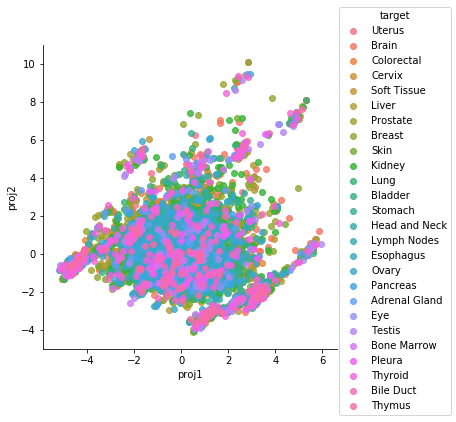

In [17]:
#Quick Feature Exploration - 

#Plot first two principal components of the data
cases_scaled = preprocessing.scale(cases)

pca = PCA(2)  
projected = pca.fit_transform(cases_scaled)
df0 = pd.DataFrame(dict(proj1=projected[:, 0], proj2=projected[:, 1], target=target))
sns.lmplot( 'proj1', 'proj2', data=df0, hue='target', fit_reg=False)
plt.figure(figsize=(20,30))
plt.show()

#Conclusion - not very informative, not very clustered

In [18]:
# Closer look at the principal components

priority = pd.DataFrame(pca.components_[1:2,:].T, cases.columns)
priority.columns = pd.Series('val')
priority = np.abs(priority)
priority.sort_values(by='val', ascending=False).iloc[:5,:]

#First principal component is dominated by base ordering: first chromosome comes is the 14th most important,
#start position comes in at 16th most important
#Second principal component is similar

,val
bases_first_T,0.433499
bases_first_G,0.405260
bases_second_G,0.360379
bases_G>A,0.265150
bases_T>A,0.262040


### III. Training Set, Testing Set

In [19]:
# Now for the aggregated data by case:

# Split the data into training and test sets
# Stratified sampling by label to ensure both the training and test sets contain a balanced 
# number of representatives of each of the labels
X_train, X_test, y_train, y_test = train_test_split(cases, target, test_size=0.2, stratify=target, random_state=0)

### IV. Building the Classifier

In [24]:
# Apply random forest classification
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=0)

### V. Evaluating Classifier Performance

In [21]:
# Print accuracy score for test set
# Note: given the averaging of subsets throughout the rf process, no cv needed here
rf_fit = rf.fit(X_train, y_train)
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
accuracy

0.26978021978021977

In [ ]:
# Plot confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=np.unique(target), index=np.unique(target))
sns.heatmap(cm/np.sum(np.sum(cm), axis=0), linewidth=0.1, cmap="YlGnBu" )
plt.show()
plt.figure(figsize=(20,20))

#Presentation is in percent of entire test population: 
# e.g., 8.6% of entire population was classifed correctly as Lung

In [ ]:
# A random classifier would have this accuracy:
1/26

In [ ]:
# Print feature importance in descending order
features = pd.DataFrame(rf_fit.feature_importances_, cases.columns)
features.columns = pd.Series('val')
features.sort_values(by='val', ascending=False) #.iloc[:5,:]